In [31]:
# Read the dataset
import scipy.io as spio
import numpy as np

BahramFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/SarahFace.mat')

AllData = np.concatenate((BahramFace['Intensification_Data'],
                            DJFace['Intensification_Data'],
                            NickFace['Intensification_Data'],
                            RoohiFace['Intensification_Data'],
                            SarahFace['Intensification_Data']), axis=0)

AllLabels = np.concatenate((BahramFace['Intensification_Label'],
                            DJFace['Intensification_Label'],
                            NickFace['Intensification_Label'],
                            RoohiFace['Intensification_Label'],
                            SarahFace['Intensification_Label']), axis=0)

print(AllData.shape, AllData.dtype, AllLabels.shape, AllLabels.dtype)
print(np.mean(AllLabels==0), np.mean(AllLabels==1), np.mean(AllLabels==2), np.mean(AllLabels==3))
print((AllLabels +  1).max(axis=0))

(18720, 205, 16) float64 (18720, 1) uint8
0.833333333333 0.166666666667 0.0 0.0
[2]


In [32]:
# Train and test split
from sklearn.model_selection import train_test_split

X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllData, AllLabels, test_size=0.30)

print(X_train_valid.shape, X_test.shape, Y_train_valid.shape, Y_test.shape)

(13104, 205, 16) (5616, 205, 16) (13104, 1) (5616, 1)


In [33]:
from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid+1).reshape(-1)==0), np.mean((Y_train_valid+1).reshape(-1)==1),
     np.mean((Y_train_valid+1).reshape(-1)==2), np.mean((Y_train_valid+1).reshape(-1)==3))

print(np.mean((Y_test+1).reshape(-1)==0), np.mean((Y_test+1).reshape(-1)==1),
     np.mean((Y_test+1).reshape(-1)==2), np.mean((Y_test+1).reshape(-1)==3))

# Y_train_valid_onehot = one_hot(labels=(Y_train_valid+1).reshape(-1), n_class=2) 
# print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
Y_test_onehot = one_hot(labels=(Y_test+1).reshape(-1), n_class=2) 
print(Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.830738705739 0.169261294261 0.0
0.0 0.839387464387 0.160612535613 0.0
(5616, 2) float64


In [34]:
# X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllData, AllLabels, test_size=0.30)
X_train_norm, X_valid_norm, Y_train, Y_valid = train_test_split(X_train_valid_norm, Y_train_valid, 
                                                                              test_size=0.30)

In [35]:
def get_batches2(X_norm, Y_labels, kernel_size_ratio=1, strides_ratio=1):
    # X normalized and Y NOT onehot encoded/vectorized
    X, Y = X_norm, Y_labels
    AllLabels = Y_labels # 100%

    # non = 0 is 87%  AllLabelZero
    # tgt = 1 is 13%  AllLabelOne
    AllLabelZero = (AllLabels==0).reshape(-1) # 87%
    AllLabelOne = (AllLabels==1).reshape(-1) # 13%

    X_non, Y_non = X[AllLabelZero], Y[AllLabelZero] # 87%
    X_tgt, Y_tgt = X[AllLabelOne], Y[AllLabelOne] # 13%
#     print('X_non.shape, Y_non.shape', X_non.shape, Y_non.shape)
#     print('X_tgt.shape, Y_tgt.shape', X_tgt.shape, Y_tgt.shape)

    # Non-target batch size for get_batches from non-target data
    batch_size = X_tgt.shape[0] # 13% -> tgt = 1 is 13%  AllLabelOne
    assert X_tgt.shape[0] == Y_tgt.shape[0]
#     print('batch_size', batch_size)
    
    # Convolvolutional minibatching technique
    (inputs, filters, kernel_size, strides, padding) = (X_non, 1, 
                                                        int(batch_size//kernel_size_ratio), 
                                                        int(batch_size//strides_ratio), 
                                                        0)
#     print('inputs.shape, filters, kernel_size, strides, padding', inputs.shape, filters, 
#           kernel_size, strides, padding)
    n_batches = int((inputs.shape[0] - kernel_size + (2*padding))//strides  + 1) 
#     print('n_batches', n_batches)
    
    # Loop over target batches: start, stop, step
    for i in range(0, n_batches, 1):
        each_X_norm = np.concatenate((X_non[(i*strides):((i*strides)+kernel_size)], X_tgt), axis=0)
        each_Y = np.concatenate((Y_non[(i*strides):((i*strides)+kernel_size)], Y_tgt), axis=0)
        each_Y_onehot = one_hot(labels=(each_Y+1).reshape(-1), n_class=2)
#         print('each_X_norm.shape, each_Y_onehot.shape', each_X_norm.shape, each_Y_onehot.shape)
#         print('np.mean(each_Y==0), np.mean(each_Y==1)', np.mean(each_Y==0), np.mean(each_Y==1))
        yield each_X_norm, each_Y_onehot

In [36]:
get_batches2(X_norm=X_valid_norm, Y_labels=Y_valid, kernel_size_ratio=1, strides_ratio=2)

<generator object get_batches2 at 0x7feae4553f10>

In [37]:
get_batches2(X_norm=X_train_norm, Y_labels=Y_train, kernel_size_ratio=1, strides_ratio=2)

<generator object get_batches2 at 0x7feae4553e08>

In [38]:
## Hyperparameters
# Input data
# batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
# print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)
print('seq_len, n_channels', seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)+1
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

seq_len, n_channels 205 16
n_classes [2]


In [39]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [40]:
# Feed the data from python/numpy to tensorflow framework
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')
print('inputs_.shape, labels_.shape', inputs_.shape, labels_.shape)

inputs_.shape, labels_.shape (?, 205, 16) (?, 2)


In [41]:
# inputs_.shape, labels_.shape (?, 205, 16) (?, 2)

# (batch, 205, 16) --> (batch, 102, 32)
conv1 = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=2, strides=1, padding='valid')
conv1 = tf.layers.batch_normalization(inputs=conv1)
conv1 = tf.nn.relu(features=conv1)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
max_pool_1 = tf.nn.dropout(x=max_pool_1, keep_prob=keep_prob_)
print('inputs_.shape, conv1.shape, max_pool_1.shape', inputs_.shape, conv1.shape, max_pool_1.shape)

# (batch, 102, 32) --> (batch, 51, 64)
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=64, kernel_size=2, strides=1, padding='same')
conv2 = tf.layers.batch_normalization(inputs=conv2)
conv2 = tf.nn.relu(features=conv2)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print('max_pool_1.shape, conv2.shape, max_pool_2.shape', max_pool_1.shape, conv2.shape, max_pool_2.shape)

# (batch, 51, 64) --> (batch, 25, 128)
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=128, kernel_size=2, strides=1, padding='valid')
conv3 = tf.layers.batch_normalization(inputs=conv3)
conv3 = tf.nn.relu(features=conv3)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print('max_pool_2.shape, conv3.shape, max_pool_3.shape', max_pool_2.shape, conv3.shape, max_pool_3.shape)

# (batch, 25, 128) --> (batch, 12, 256)
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=256, kernel_size=2, strides=1, padding='valid')
conv4 = tf.layers.batch_normalization(inputs=conv4)
conv4 = tf.nn.relu(features=conv4)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print('max_pool_3.shape, conv4.shape, max_pool_4.shape', max_pool_3.shape, conv4.shape, max_pool_4.shape)

# (batch, 12, 256) --> (batch, 12*256) --> (batch, 12*256*2)
flat = tf.reshape(max_pool_4, (-1, 12*256))
dense = tf.layers.dense(flat, 12*256*2)
dense = tf.layers.batch_normalization(inputs=dense)
dense = tf.nn.relu(features=dense)
dense = tf.nn.dropout(dense, keep_prob=keep_prob_)
print('max_pool_4.shape, flat.shape, dense.shape:', max_pool_4.shape, flat.shape, dense.shape)

# (batch, 12*256*2) --> (batch, 2)
logits = tf.layers.dense(dense, n_classes)
probs = tf.nn.softmax(logits=logits)
print('dense.shape, logits.shape:', dense.shape, logits.shape)

inputs_.shape, conv1.shape, max_pool_1.shape (?, 205, 16) (?, 204, 32) (?, 102, 32)
max_pool_1.shape, conv2.shape, max_pool_2.shape (?, 102, 32) (?, 102, 64) (?, 51, 64)
max_pool_2.shape, conv3.shape, max_pool_3.shape (?, 51, 64) (?, 50, 128) (?, 25, 128)
max_pool_3.shape, conv4.shape, max_pool_4.shape (?, 25, 128) (?, 24, 256) (?, 12, 256)
max_pool_4.shape, flat.shape, dense.shape: (?, 12, 256) (?, 3072) (?, 6144)
dense.shape, logits.shape: (?, 6144) (?, 2)


In [42]:
# Backward pass: error backpropagation
# Cost function
cost = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost_ave = tf.reduce_mean(input_tensor=cost)
print('cost, cost_ave:', cost, cost_ave)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)
print('optimizer:', optimizer)

# Accuracy
correct_pred = tf.equal(x=tf.argmax(input=probs, axis=1), y=tf.argmax(input=labels_, axis=1))
correct_pred_ave = tf.reduce_mean(input_tensor=tf.cast(x=correct_pred, dtype=tf.float32))
print('correct_pred, correct_pred_ave:', correct_pred, correct_pred_ave)

# Confusion matrix
confusion = tf.confusion_matrix(predictions=tf.argmax(input=probs, axis=1), 
                                labels=tf.argmax(input=labels_, axis=1), dtype=tf.float32)
print('confusion', confusion)

cost, cost_ave: Tensor("Reshape_11:0", shape=(?,), dtype=float32) Tensor("Mean_4:0", shape=(), dtype=float32)
optimizer: name: "Adam_2"
op: "NoOp"
input: "^Adam_2/update_conv1d_8/kernel/ApplyAdam"
input: "^Adam_2/update_conv1d_8/bias/ApplyAdam"
input: "^Adam_2/update_batch_normalization_10/beta/ApplyAdam"
input: "^Adam_2/update_batch_normalization_10/gamma/ApplyAdam"
input: "^Adam_2/update_conv1d_9/kernel/ApplyAdam"
input: "^Adam_2/update_conv1d_9/bias/ApplyAdam"
input: "^Adam_2/update_batch_normalization_11/beta/ApplyAdam"
input: "^Adam_2/update_batch_normalization_11/gamma/ApplyAdam"
input: "^Adam_2/update_conv1d_10/kernel/ApplyAdam"
input: "^Adam_2/update_conv1d_10/bias/ApplyAdam"
input: "^Adam_2/update_batch_normalization_12/beta/ApplyAdam"
input: "^Adam_2/update_batch_normalization_12/gamma/ApplyAdam"
input: "^Adam_2/update_conv1d_11/kernel/ApplyAdam"
input: "^Adam_2/update_conv1d_11/bias/ApplyAdam"
input: "^Adam_2/update_batch_normalization_13/beta/ApplyAdam"
input: "^Adam_2/upda

In [43]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

# hyperparameters
epochs = 1000 # num iterations for updating model
kernel_size_ratios = 1 # conv size for conv minibatching 
strides_ratios = 1 # conv stride for conv minibatching

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Minibatching techniques tgt batch size: kernel_size_ratio
    for k in range(0, kernel_size_ratios, 1):

        # Minibatching techniques sampling: strides_ratio
        for s in range(0, strides_ratios, 1):

            # Loop over epochs
            for e in range(0, epochs, 1):

                # Loop over batches
                for x, y in get_batches2(X_norm=X_train_norm, Y_labels=Y_train):   

                    ######################## Training
                    # Feed dictionary
                    feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}

                    # Loss
                    loss, _ , acc = sess.run(fetches=[cost_ave, optimizer, correct_pred_ave], feed_dict = feed)
                    train_acc.append(acc)
                    train_loss.append(loss)

                    ################## Validation
                    acc_batch = []
                    loss_batch = []    
                    # Loop over batches
                    for x, y in get_batches2(X_norm=X_valid_norm, Y_labels=Y_valid):

                        # Feed dictionary
                        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

                        # Loss
                        loss, acc = sess.run(fetches=[cost_ave, correct_pred_ave], feed_dict = feed)
                        acc_batch.append(acc)
                        loss_batch.append(loss)

                    # Store
                    valid_acc.append(np.mean(acc_batch))
                    valid_loss.append(np.mean(loss_batch))

                # Print info for every iter/epoch
                print("Epoch: {}/{}".format(e+1, epochs),
#                       "kernel_size_ratio: {}/{}".format(k+1, kernel_size_ratios),
#                       "strides_ratio: {}/{}".format(s+1, strides_ratios),
                      "Train loss: {:6f}".format(np.mean(train_loss)),
                      "Valid loss: {:.6f}".format(np.mean(valid_loss)),
                      "Train acc: {:6f}".format(np.mean(train_acc)),
                      "Valid acc: {:.6f}".format(np.mean(valid_acc)))
                
    saver.save(sess,"checkpoints/dcnn-face.ckpt")

Epoch: 1/1000 Train loss: 1.541189 Valid loss: 0.767307 Train acc: 0.499428 Valid acc: 0.500000
Epoch: 2/1000 Train loss: 1.422981 Valid loss: 0.740371 Train acc: 0.500531 Valid acc: 0.503815
Epoch: 3/1000 Train loss: 1.312075 Valid loss: 0.727962 Train acc: 0.501171 Valid acc: 0.503921
Epoch: 4/1000 Train loss: 1.223123 Valid loss: 0.720068 Train acc: 0.501103 Valid acc: 0.503793
Epoch: 5/1000 Train loss: 1.140298 Valid loss: 0.714903 Train acc: 0.502533 Valid acc: 0.504161
Epoch: 6/1000 Train loss: 1.083531 Valid loss: 0.710772 Train acc: 0.504003 Valid acc: 0.509766
Epoch: 7/1000 Train loss: 1.039944 Valid loss: 0.707583 Train acc: 0.504902 Valid acc: 0.514340
Epoch: 8/1000 Train loss: 1.003322 Valid loss: 0.705173 Train acc: 0.506495 Valid acc: 0.516255
Epoch: 9/1000 Train loss: 0.974504 Valid loss: 0.703205 Train acc: 0.508515 Valid acc: 0.518910
Epoch: 10/1000 Train loss: 0.950856 Valid loss: 0.701481 Train acc: 0.509387 Valid acc: 0.532022
Epoch: 11/1000 Train loss: 0.930176 Val

Epoch: 86/1000 Train loss: 0.672838 Valid loss: 0.626162 Train acc: 0.624852 Valid acc: 0.694781
Epoch: 87/1000 Train loss: 0.671572 Valid loss: 0.625101 Train acc: 0.626014 Valid acc: 0.695877
Epoch: 88/1000 Train loss: 0.670233 Valid loss: 0.624053 Train acc: 0.627119 Valid acc: 0.696915
Epoch: 89/1000 Train loss: 0.668981 Valid loss: 0.623018 Train acc: 0.628251 Valid acc: 0.697944
Epoch: 90/1000 Train loss: 0.667629 Valid loss: 0.621996 Train acc: 0.629419 Valid acc: 0.698968
Epoch: 91/1000 Train loss: 0.666286 Valid loss: 0.620989 Train acc: 0.630517 Valid acc: 0.699933
Epoch: 92/1000 Train loss: 0.664933 Valid loss: 0.619980 Train acc: 0.631633 Valid acc: 0.700921
Epoch: 93/1000 Train loss: 0.663620 Valid loss: 0.618974 Train acc: 0.632752 Valid acc: 0.701885
Epoch: 94/1000 Train loss: 0.662363 Valid loss: 0.617974 Train acc: 0.633791 Valid acc: 0.702819
Epoch: 95/1000 Train loss: 0.661032 Valid loss: 0.616970 Train acc: 0.634956 Valid acc: 0.703783
Epoch: 96/1000 Train loss: 0.6

Epoch: 170/1000 Train loss: 0.584973 Valid loss: 0.555852 Train acc: 0.694499 Valid acc: 0.749745
Epoch: 171/1000 Train loss: 0.584150 Valid loss: 0.555232 Train acc: 0.695099 Valid acc: 0.750114
Epoch: 172/1000 Train loss: 0.583381 Valid loss: 0.554618 Train acc: 0.695648 Valid acc: 0.750471
Epoch: 173/1000 Train loss: 0.582564 Valid loss: 0.554008 Train acc: 0.696250 Valid acc: 0.750818
Epoch: 174/1000 Train loss: 0.581737 Valid loss: 0.553397 Train acc: 0.696849 Valid acc: 0.751170
Epoch: 175/1000 Train loss: 0.580936 Valid loss: 0.552783 Train acc: 0.697417 Valid acc: 0.751508
Epoch: 176/1000 Train loss: 0.580168 Valid loss: 0.552180 Train acc: 0.697975 Valid acc: 0.751846
Epoch: 177/1000 Train loss: 0.579374 Valid loss: 0.551584 Train acc: 0.698538 Valid acc: 0.752177
Epoch: 178/1000 Train loss: 0.578616 Valid loss: 0.550998 Train acc: 0.699076 Valid acc: 0.752499
Epoch: 179/1000 Train loss: 0.577848 Valid loss: 0.550427 Train acc: 0.699632 Valid acc: 0.752801
Epoch: 180/1000 Trai

Epoch: 254/1000 Train loss: 0.531417 Valid loss: 0.517352 Train acc: 0.731793 Valid acc: 0.770422
Epoch: 255/1000 Train loss: 0.530902 Valid loss: 0.517006 Train acc: 0.732143 Valid acc: 0.770611
Epoch: 256/1000 Train loss: 0.530395 Valid loss: 0.516664 Train acc: 0.732488 Valid acc: 0.770796
Epoch: 257/1000 Train loss: 0.529898 Valid loss: 0.516326 Train acc: 0.732826 Valid acc: 0.770974
Epoch: 258/1000 Train loss: 0.529393 Valid loss: 0.515992 Train acc: 0.733169 Valid acc: 0.771150
Epoch: 259/1000 Train loss: 0.528889 Valid loss: 0.515667 Train acc: 0.733504 Valid acc: 0.771315
Epoch: 260/1000 Train loss: 0.528408 Valid loss: 0.515346 Train acc: 0.733837 Valid acc: 0.771478
Epoch: 261/1000 Train loss: 0.527918 Valid loss: 0.515023 Train acc: 0.734160 Valid acc: 0.771647
Epoch: 262/1000 Train loss: 0.527452 Valid loss: 0.514701 Train acc: 0.734461 Valid acc: 0.771805
Epoch: 263/1000 Train loss: 0.526977 Valid loss: 0.514373 Train acc: 0.734795 Valid acc: 0.771981
Epoch: 264/1000 Trai

Epoch: 338/1000 Train loss: 0.495272 Valid loss: 0.494969 Train acc: 0.755328 Valid acc: 0.781670
Epoch: 339/1000 Train loss: 0.494895 Valid loss: 0.494765 Train acc: 0.755577 Valid acc: 0.781772
Epoch: 340/1000 Train loss: 0.494513 Valid loss: 0.494559 Train acc: 0.755814 Valid acc: 0.781865
Epoch: 341/1000 Train loss: 0.494151 Valid loss: 0.494355 Train acc: 0.756036 Valid acc: 0.781956
Epoch: 342/1000 Train loss: 0.493782 Valid loss: 0.494153 Train acc: 0.756262 Valid acc: 0.782050
Epoch: 343/1000 Train loss: 0.493421 Valid loss: 0.493950 Train acc: 0.756488 Valid acc: 0.782153
Epoch: 344/1000 Train loss: 0.493048 Valid loss: 0.493753 Train acc: 0.756717 Valid acc: 0.782248
Epoch: 345/1000 Train loss: 0.492675 Valid loss: 0.493560 Train acc: 0.756952 Valid acc: 0.782344
Epoch: 346/1000 Train loss: 0.492306 Valid loss: 0.493369 Train acc: 0.757182 Valid acc: 0.782429
Epoch: 347/1000 Train loss: 0.491941 Valid loss: 0.493172 Train acc: 0.757412 Valid acc: 0.782517
Epoch: 348/1000 Trai

Epoch: 422/1000 Train loss: 0.466343 Valid loss: 0.480686 Train acc: 0.773021 Valid acc: 0.787809
Epoch: 423/1000 Train loss: 0.466008 Valid loss: 0.480545 Train acc: 0.773218 Valid acc: 0.787865
Epoch: 424/1000 Train loss: 0.465688 Valid loss: 0.480406 Train acc: 0.773413 Valid acc: 0.787922
Epoch: 425/1000 Train loss: 0.465370 Valid loss: 0.480272 Train acc: 0.773604 Valid acc: 0.787981
Epoch: 426/1000 Train loss: 0.465049 Valid loss: 0.480135 Train acc: 0.773794 Valid acc: 0.788044
Epoch: 427/1000 Train loss: 0.464732 Valid loss: 0.480003 Train acc: 0.773979 Valid acc: 0.788100
Epoch: 428/1000 Train loss: 0.464415 Valid loss: 0.479866 Train acc: 0.774171 Valid acc: 0.788163
Epoch: 429/1000 Train loss: 0.464097 Valid loss: 0.479723 Train acc: 0.774362 Valid acc: 0.788225
Epoch: 430/1000 Train loss: 0.463789 Valid loss: 0.479581 Train acc: 0.774550 Valid acc: 0.788282
Epoch: 431/1000 Train loss: 0.463469 Valid loss: 0.479444 Train acc: 0.774746 Valid acc: 0.788336
Epoch: 432/1000 Trai

Epoch: 506/1000 Train loss: 0.440156 Valid loss: 0.471335 Train acc: 0.788368 Valid acc: 0.791656
Epoch: 507/1000 Train loss: 0.439851 Valid loss: 0.471251 Train acc: 0.788548 Valid acc: 0.791699
Epoch: 508/1000 Train loss: 0.439543 Valid loss: 0.471169 Train acc: 0.788721 Valid acc: 0.791739
Epoch: 509/1000 Train loss: 0.439237 Valid loss: 0.471095 Train acc: 0.788898 Valid acc: 0.791769
Epoch: 510/1000 Train loss: 0.438928 Valid loss: 0.471018 Train acc: 0.789068 Valid acc: 0.791796
Epoch: 511/1000 Train loss: 0.438625 Valid loss: 0.470939 Train acc: 0.789237 Valid acc: 0.791823
Epoch: 512/1000 Train loss: 0.438319 Valid loss: 0.470857 Train acc: 0.789416 Valid acc: 0.791854
Epoch: 513/1000 Train loss: 0.438006 Valid loss: 0.470781 Train acc: 0.789597 Valid acc: 0.791886
Epoch: 514/1000 Train loss: 0.437693 Valid loss: 0.470711 Train acc: 0.789777 Valid acc: 0.791915
Epoch: 515/1000 Train loss: 0.437389 Valid loss: 0.470645 Train acc: 0.789950 Valid acc: 0.791943
Epoch: 516/1000 Trai

Epoch: 590/1000 Train loss: 0.414456 Valid loss: 0.467402 Train acc: 0.802857 Valid acc: 0.793575
Epoch: 591/1000 Train loss: 0.414153 Valid loss: 0.467390 Train acc: 0.803029 Valid acc: 0.793591
Epoch: 592/1000 Train loss: 0.413854 Valid loss: 0.467386 Train acc: 0.803199 Valid acc: 0.793604
Epoch: 593/1000 Train loss: 0.413547 Valid loss: 0.467393 Train acc: 0.803371 Valid acc: 0.793611
Epoch: 594/1000 Train loss: 0.413251 Valid loss: 0.467400 Train acc: 0.803541 Valid acc: 0.793617
Epoch: 595/1000 Train loss: 0.412945 Valid loss: 0.467404 Train acc: 0.803712 Valid acc: 0.793625
Epoch: 596/1000 Train loss: 0.412635 Valid loss: 0.467395 Train acc: 0.803887 Valid acc: 0.793632
Epoch: 597/1000 Train loss: 0.412324 Valid loss: 0.467399 Train acc: 0.804058 Valid acc: 0.793641
Epoch: 598/1000 Train loss: 0.412024 Valid loss: 0.467396 Train acc: 0.804218 Valid acc: 0.793655
Epoch: 599/1000 Train loss: 0.411718 Valid loss: 0.467386 Train acc: 0.804381 Valid acc: 0.793671
Epoch: 600/1000 Trai

Epoch: 674/1000 Train loss: 0.388433 Valid loss: 0.470307 Train acc: 0.817086 Valid acc: 0.794482
Epoch: 675/1000 Train loss: 0.388116 Valid loss: 0.470388 Train acc: 0.817255 Valid acc: 0.794486
Epoch: 676/1000 Train loss: 0.387816 Valid loss: 0.470472 Train acc: 0.817413 Valid acc: 0.794487
Epoch: 677/1000 Train loss: 0.387503 Valid loss: 0.470550 Train acc: 0.817575 Valid acc: 0.794495
Epoch: 678/1000 Train loss: 0.387190 Valid loss: 0.470630 Train acc: 0.817745 Valid acc: 0.794505
Epoch: 679/1000 Train loss: 0.386887 Valid loss: 0.470701 Train acc: 0.817906 Valid acc: 0.794512
Epoch: 680/1000 Train loss: 0.386569 Valid loss: 0.470775 Train acc: 0.818072 Valid acc: 0.794515
Epoch: 681/1000 Train loss: 0.386256 Valid loss: 0.470855 Train acc: 0.818238 Valid acc: 0.794522
Epoch: 682/1000 Train loss: 0.385936 Valid loss: 0.470936 Train acc: 0.818411 Valid acc: 0.794530
Epoch: 683/1000 Train loss: 0.385629 Valid loss: 0.471013 Train acc: 0.818577 Valid acc: 0.794539
Epoch: 684/1000 Trai

Epoch: 758/1000 Train loss: 0.362241 Valid loss: 0.479887 Train acc: 0.830832 Valid acc: 0.794809
Epoch: 759/1000 Train loss: 0.361932 Valid loss: 0.480046 Train acc: 0.830994 Valid acc: 0.794805
Epoch: 760/1000 Train loss: 0.361631 Valid loss: 0.480214 Train acc: 0.831150 Valid acc: 0.794799
Epoch: 761/1000 Train loss: 0.361320 Valid loss: 0.480361 Train acc: 0.831308 Valid acc: 0.794800
Epoch: 762/1000 Train loss: 0.361015 Valid loss: 0.480532 Train acc: 0.831469 Valid acc: 0.794795
Epoch: 763/1000 Train loss: 0.360715 Valid loss: 0.480701 Train acc: 0.831622 Valid acc: 0.794791
Epoch: 764/1000 Train loss: 0.360413 Valid loss: 0.480863 Train acc: 0.831780 Valid acc: 0.794790
Epoch: 765/1000 Train loss: 0.360105 Valid loss: 0.481018 Train acc: 0.831937 Valid acc: 0.794785
Epoch: 766/1000 Train loss: 0.359794 Valid loss: 0.481177 Train acc: 0.832098 Valid acc: 0.794781
Epoch: 767/1000 Train loss: 0.359485 Valid loss: 0.481333 Train acc: 0.832257 Valid acc: 0.794775
Epoch: 768/1000 Trai

Epoch: 842/1000 Train loss: 0.337017 Valid loss: 0.495813 Train acc: 0.843654 Valid acc: 0.794590
Epoch: 843/1000 Train loss: 0.336735 Valid loss: 0.496034 Train acc: 0.843794 Valid acc: 0.794586
Epoch: 844/1000 Train loss: 0.336448 Valid loss: 0.496239 Train acc: 0.843938 Valid acc: 0.794584
Epoch: 845/1000 Train loss: 0.336158 Valid loss: 0.496466 Train acc: 0.844083 Valid acc: 0.794581
Epoch: 846/1000 Train loss: 0.335871 Valid loss: 0.496675 Train acc: 0.844228 Valid acc: 0.794582
Epoch: 847/1000 Train loss: 0.335576 Valid loss: 0.496896 Train acc: 0.844373 Valid acc: 0.794580
Epoch: 848/1000 Train loss: 0.335290 Valid loss: 0.497112 Train acc: 0.844515 Valid acc: 0.794573
Epoch: 849/1000 Train loss: 0.335007 Valid loss: 0.497326 Train acc: 0.844657 Valid acc: 0.794568
Epoch: 850/1000 Train loss: 0.334724 Valid loss: 0.497533 Train acc: 0.844800 Valid acc: 0.794561
Epoch: 851/1000 Train loss: 0.334435 Valid loss: 0.497747 Train acc: 0.844946 Valid acc: 0.794555
Epoch: 852/1000 Trai

Epoch: 926/1000 Train loss: 0.313556 Valid loss: 0.516512 Train acc: 0.855265 Valid acc: 0.793967
Epoch: 927/1000 Train loss: 0.313288 Valid loss: 0.516811 Train acc: 0.855396 Valid acc: 0.793958
Epoch: 928/1000 Train loss: 0.313024 Valid loss: 0.517089 Train acc: 0.855527 Valid acc: 0.793955
Epoch: 929/1000 Train loss: 0.312758 Valid loss: 0.517368 Train acc: 0.855655 Valid acc: 0.793952
Epoch: 930/1000 Train loss: 0.312492 Valid loss: 0.517644 Train acc: 0.855786 Valid acc: 0.793944
Epoch: 931/1000 Train loss: 0.312229 Valid loss: 0.517925 Train acc: 0.855916 Valid acc: 0.793936
Epoch: 932/1000 Train loss: 0.311964 Valid loss: 0.518200 Train acc: 0.856045 Valid acc: 0.793930
Epoch: 933/1000 Train loss: 0.311701 Valid loss: 0.518481 Train acc: 0.856174 Valid acc: 0.793921
Epoch: 934/1000 Train loss: 0.311443 Valid loss: 0.518752 Train acc: 0.856302 Valid acc: 0.793915
Epoch: 935/1000 Train loss: 0.311179 Valid loss: 0.519026 Train acc: 0.856431 Valid acc: 0.793905
Epoch: 936/1000 Trai

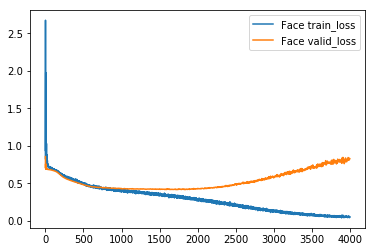

In [44]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='Face train_loss')
mplot.plot(valid_loss, label='Face valid_loss')
mplot.legend()
mplot.show()

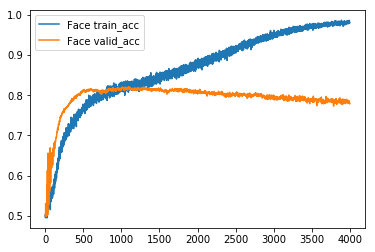

In [45]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc, label='Face train_acc')
mplot.plot(valid_acc, label='Face valid_acc')
mplot.legend()
mplot.show()

In [46]:
listcost_ave, listcorrect_pred_ave, listconfusion = [], [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
    
    # Loop over batches
    for x, y in get_batches(batch_size=100, X=X_test_norm, y=Y_test_onehot):

        # Feed dictionary
        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

        # Loss
        arrcost_ave, arrcorrect_pred_ave, arrconfusion = sess.run([
            cost_ave, correct_pred_ave, confusion], feed_dict = feed)
        
        listcost_ave.append(arrcost_ave) 
        listcorrect_pred_ave.append(arrcorrect_pred_ave)
        listconfusion.append(arrconfusion)

INFO:tensorflow:Restoring parameters from checkpoints/dcnn-face.ckpt


In [47]:
len(listcorrect_pred_ave), len(listcost_ave), len(listconfusion)

(56, 56, 56)

In [48]:
cost_ave_mean = np.array(listcost_ave, dtype=arrcost_ave.dtype).mean(axis=0)
correct_pred_ave_mean = np.array(listcorrect_pred_ave, dtype=arrcorrect_pred_ave.dtype).mean(axis=0)
confusion_mean = np.array(listconfusion, dtype=arrconfusion.dtype).mean(axis=0)
print('cost_ave_mean, correct_pred_ave_mean, confusion_mean.shape:', 
     cost_ave_mean, correct_pred_ave_mean, confusion_mean.shape)

cost_ave_mean, correct_pred_ave_mean, confusion_mean.shape: 0.512763 0.857143 (2, 2)


In [49]:
confusion_mean

array([[ 74.55357361,   9.39285755],
       [  4.89285707,  11.16071415]], dtype=float32)

In [50]:
# accuracy or 1- loss
accuracy = (confusion_mean[0, 0] + confusion_mean[1, 1])/ (confusion_mean[0, 0] + confusion_mean[0, 1] + 
                                                confusion_mean[1, 0] + confusion_mean[1, 1])
print('accuracy vs correct_pred_ave_mean:', accuracy, correct_pred_ave_mean)

accuracy vs correct_pred_ave_mean: 0.857143 0.857143


In [51]:
print('(correct_pred_ave_mean - accuracy):', correct_pred_ave_mean - accuracy)  

(correct_pred_ave_mean - accuracy): 5.96046e-08


In [52]:
# accuracy or 1- loss
loss = (confusion_mean[1, 0] + confusion_mean[0, 1])/ (confusion_mean[0, 0] + confusion_mean[0, 1] + 
                                                       confusion_mean[1, 0] + confusion_mean[1, 1])
print('loss or (1-acc):', loss)

loss or (1-acc): 0.142857


In [53]:
# sensitivity: TP/ (TP+FNs)  TPR or recall for multiclass
# 1st col or true prediction condition
sensitivity = confusion_mean[0, 0]/ (confusion_mean[0, 0] + 
                                     confusion_mean[1, 0])
print('sensitivity:', sensitivity)

sensitivity: 0.938413


In [54]:
# specificity: TN/ (TN + FPs) TNR or recall for multiclass
# 2nd col or false prediction condition
# (1st row, 2nd col)/ 
specificity = confusion_mean[1, 1]/ (confusion_mean[0, 1] + 
                                     confusion_mean[1, 1])
print('specificity:', specificity)

specificity: 0.543006


In [55]:
# precision: TP / (TP + FPs) for 1st row
precision = confusion_mean[0, 0]/ (confusion_mean[0, 0] + confusion_mean[0, 1])
print('precision:', precision)

precision: 0.888109


In [56]:
# precision: TP / (TP + FP) for 2nd row
precision2 = confusion_mean[1, 0]/ (confusion_mean[1, 0] + confusion_mean[1, 1])
print('precision2:', precision2)

precision2: 0.304783


In [57]:
print('total:', (confusion_mean[0, 0] + confusion_mean[0, 1] + confusion_mean[1, 0] + confusion_mean[1, 1]))

total: 100.0


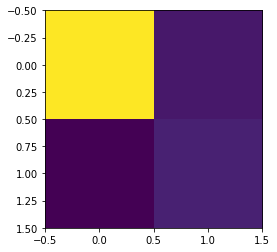

In [58]:
mplot.imshow(confusion_mean)
mplot.show()
mplot.legend()